# Sarsa Lambda Control

In [83]:
import numpy as np
import easy21env as easy21
import easy21_table
import pandas as pd
import random
import easy21_table
from numba import njit
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)

# Step size
discount_factor = 0.9
sarsa_lambda = 1.0

N0 = 100

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [84]:
q = easy21_table.create_q()
q_N = easy21_table.create_q()

In [85]:

# Epsilon greedy policy
@njit
def choose_action(epsilon, dealer_score, player_score):
    if random.random() < epsilon: 
        action = 1 if random.random() > 0.5  else 0 
    else:
        q_action_0 = easy21_table.get_q(q, dealer_score, player_score, 0)
        q_action_1 = easy21_table.get_q(q, dealer_score, player_score, 1)
        if q_action_0 > q_action_1:
            action = 0
        else:
            action = 1
    return action

@njit
def episode(q, q_N):
    #e = easy21_table.create_e()
    e = np.zeros((10, 21, 2))
    for i in range(1000000):
        e = easy21_table.reset_e(e)
        player_card_t0 = easy21.take(0)
        dealer_card_t0 = easy21.take(0)
        player_score_t0 = player_card_t0[0]
        dealer_score_t0 = dealer_card_t0[0]
        hit_N = easy21_table.get_q(q_N, dealer_score_t0, player_score_t0, 1)
        stick_N = easy21_table.get_q(q_N, dealer_score_t0, player_score_t0, 0)
        total_S_N = hit_N + stick_N
        epsilon = N0 / (N0 + total_S_N)
        action_t0 =  choose_action(epsilon, dealer_score_t0, player_score_t0)
        states = []
        terminal = False
        while terminal == False:
            N_sa = easy21_table.get_q(q_N, dealer_score_t0, player_score_t0, action_t0)
            step_size = 1 / N_sa if N_sa > 0 else 1
                
            states.append((dealer_score_t0, player_score_t0, action_t0))
            q_N = easy21_table.set_q(q_N, dealer_score_t0, player_score_t0, action_t0,
                                     easy21_table.get_q(q_N, dealer_score_t0, player_score_t0, action_t0) + 1)
            dealer_card_t1, player_score_t1, terminal, reward = easy21.step(dealer_card_t0, player_score_t0, action_t0)
            dealer_score_t1 = dealer_card_t1[0]
            q_t0 = easy21_table.get_q(q, dealer_score_t0, player_score_t0, action_t0)
            e = easy21_table.increment_e(e, dealer_score_t0, player_score_t0, action_t0)
            
            if terminal:
                error = reward - q_t0
            else:
                action_t1 = choose_action(epsilon, dealer_score_t1, player_score_t1)
                q_t1 = easy21_table.get_q(q, dealer_score_t1, player_score_t1, action_t1)
                error = reward + discount_factor * q_t1 - q_t0
                
            q += step_size * error * e
            e = easy21_table.decay_e(e, discount_factor, sarsa_lambda)
            """
            for my_dealer_score, my_player_score, my_action in states:
                q = easy21_table.set_q(q, my_dealer_score, my_player_score, my_action,
                            easy21_table.get_q(q, my_dealer_score, my_player_score, my_action)
                             + step_size * error * easy21_table.get_q(e, my_dealer_score, my_player_score, my_action))
                e = easy21_table.decay_state_e(e, my_dealer_score, my_player_score,
                                               my_action, discount_factor, sarsa_lambda)
            """
            if not terminal:
                dealer_card_t0 = dealer_card_t1
                player_score_t0 = player_score_t1 
                action_t0 = action_t1 
    return q, q_N

In [86]:
q, q_N = episode(q, q_N)

In [87]:
z = np.zeros((30, 11))
x, y = np.meshgrid(range(1,22), range(1,11))

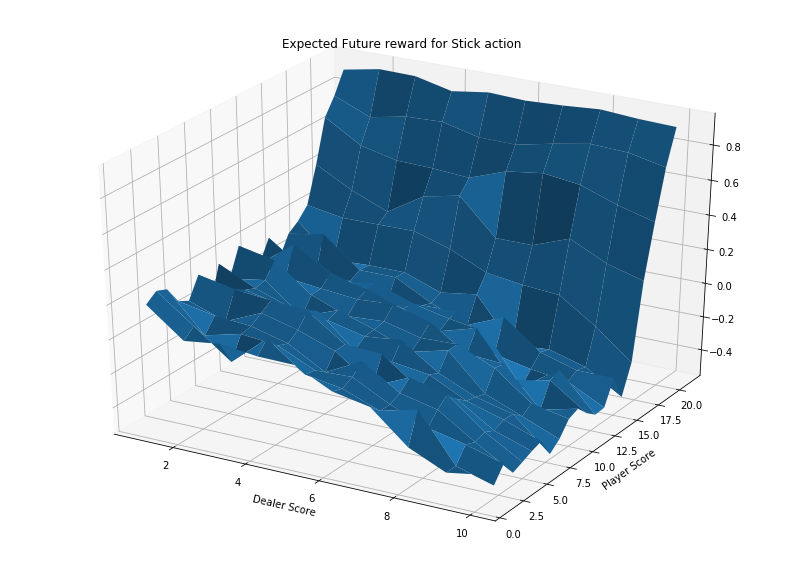

In [ ]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , q[:,:,0])
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for Stick action')

In [ ]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , q[:,:,1])
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for Take action')